# Vignette 1: Introduction to NetworkCommons

Networkcommons is a package which allows users to download data and prior knowledge networks to perform network inference using different methodologies. The package also provides different visualization and evaluation strategies.

In this vignette, we will use a single contrast (Afatinib-treated vs DMSO-treated ASPC cells) from the PANACEA dataset to contextualise a signalling network from OmniPath. For this, we will:

1. Download the data from the server.

2. Perform DGE analysis with DESeq2 and TF activity estimation with the CollecTRI GRN and decoupler-py (univariate linear model) to obtain the sign of the perturbation's effects.

3. Contextualise the network signalling network, using EGFR as perturbation (inhibited by Afatinib) and TFs as measurements, using several baseline methodologies.

4. Visualise the networks.

First, we need to import the packages that we're going to use in this notebook

In [1]:
import networkcommons as nc
import pandas as pd
import networkx as nx
import decoupler as dc
import omnipath as op
import numpy as np
import corneto as cn
from IPython.display import HTML, display

/home/victo/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Processing of transcriptomics data

We can see the available datasets using this util function. Currently only PANACEA is available, but the aim is to incorporate more perturbational datasets, from both transcriptomics and phosphoproteomics.

In [2]:
nc.get_available_datasets()

['decryptm', 'panacea']

Now, we download PANACEA. Since it contains transcriptomics profiles from 32 drugs and 11 cell lines, we will filter the dataframe for just one particular contrast as an example.

In [3]:
panacea_metadata, panacea_countdata = nc.download_dataset('panacea')
singlec_metadata = panacea_metadata[(panacea_metadata['group'] == 'ASPC_DMSO') | (panacea_metadata['group'] == 'ASPC_AFATINIB')]
singlec_samples = singlec_metadata['sample_ID'].tolist()
singlec_countdata = panacea_countdata[['gene_symbol'] + singlec_samples]

In [4]:
singlec_countdata.head()

,gene_symbol,ASPC_DMSO__24,ASPC_DMSO__24.1,ASPC_DMSO__24.2,ASPC_DMSO__24.3,ASPC_DMSO__24.4,ASPC_DMSO__24.5,ASPC_DMSO_0_24,ASPC_DMSO_0_24.1,ASPC_DMSO_0_24.2,...,ASPC_DMSO_0_24.38,ASPC_DMSO_0_24.39,ASPC_DMSO_0_24.40,ASPC_DMSO_0_24.41,ASPC_DMSO_0_24.42,ASPC_DMSO_0_24.43,ASPC_DMSO_0_24.44,ASPC_DMSO_0_24.45,ASPC_DMSO_0_24.46,ASPC_DMSO_0_24.47
0,A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NAT2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,ADA,6,6,9,19,7,7,1,6,3,...,6,0,0,1,1,6,2,0,12,1
3,CDH2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,AKT3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
singlec_metadata.head()

,sample_ID,group
0,ASPC_DMSO__24,ASPC_DMSO
1,ASPC_DMSO__24.1,ASPC_DMSO
2,ASPC_DMSO__24.2,ASPC_DMSO
3,ASPC_DMSO__24.3,ASPC_DMSO
4,ASPC_DMSO__24.4,ASPC_DMSO


Now, we will perform DGE analysis using DESeq2 via rpy2.

In [6]:
results = nc.deseq2_analysis(singlec_countdata, singlec_metadata)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





Next, we will perform TF activity estimation with decoupler-py. In this vignette we will focus on the signalling network from network, thus our measurement layer will be at the TF level. NetworkCommons contains a util function to prepare DESeq2 output to be used with decoupler. 
We retrieve then the CollecTRI TF gene sets via decoupler and perform the enrichment analysis using univariate linear model (ulm)

In [7]:
decoupler_input = nc.decoupler_formatter(results, 'stat')
collectri_net = dc.get_collectri()
dc_estimates, dc_pvals = dc.run_ulm(decoupler_input, collectri_net)

Networkcommons also provides a util function to convert this output in a dictionary of measurements, which is what the methods will require as inputs.

In [8]:
measurements = nc.targetlayer_formatter(dc_estimates.T, 'EGFR')

## 2. Network inference

We have now our set of TF measurements, which we will use as footprints of the perturbation induced by Afatinib. We will use these to contextualised a general PPI network retrieved from OmniPath.

In [9]:
network = nc.get_omnipath()

In [10]:
graph = nc.network_from_df(network)

Afatinib targets EGFR by inhibition, so we will create a source dictionary containing the origin of perturbation, EGFR, and the sign of the perturbation (negative, therefore -1).

In [11]:
source_df = pd.DataFrame({'source': ['EGFR'], 
                          'sign': [1]}, columns=['source', 'sign'])
source_df.set_index('source', inplace=True)
sources = source_df['sign'].to_dict()

### 2.1 CORNETO

*This section is under construction, results may differ*

In [12]:
corneto_network = nc.run_corneto_carnival(graph, sources, measurements)

(CORNETO) abr 24 03:25:20    - INFO    : 1/1 inputs mapped to the graph
(CORNETO) abr 24 03:25:20    - INFO    : 16/25 outputs mapped to the graph
(CORNETO) abr 24 03:25:20    - INFO    : Pruning the graph with size: V x E = (4931, 13071)...
(CORNETO) abr 24 03:25:22    - INFO    : Finished. Final size: V x E = (1182, 5751).
(CORNETO) abr 24 03:25:22    - INFO    : 1/1 inputs after pruning.
(CORNETO) abr 24 03:25:22    - INFO    : 10/16 outputs after pruning.
(CORNETO) abr 24 03:25:22    - INFO    : Converting into a flow graph...
(CORNETO) abr 24 03:25:22    - INFO    : Creating a network flow problem...
(CORNETO) abr 24 03:25:23    - INFO    : Preprocess completed.
                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) abr 24 03:25:23 : Your problem has 26727 variables, 22 constraints, and 0 parameters.
(CVXPY) abr 24 03:25:23 : It is compliant with the following grammars:

IndexError: list index out of range

In [ ]:
a = nc.visualize_graph_simple(corneto_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

### 2.2 Baseline methods: shortest paths, all paths, sign consistency, Personalised PageRank

NetworkCommons also includes several baseline methods. These methods follow very simple assumptions, and therefore are well suited to be compared against more advanced methodologies.

**Shortest paths**

This method retrieves the shortest path between source and target nodes. In the case where there are many paths with the same length, all these paths will be retrieved.

In [13]:
shortest_path_network, shortest_paths_list = nc.run_shortest_paths(graph, sources, measurements)

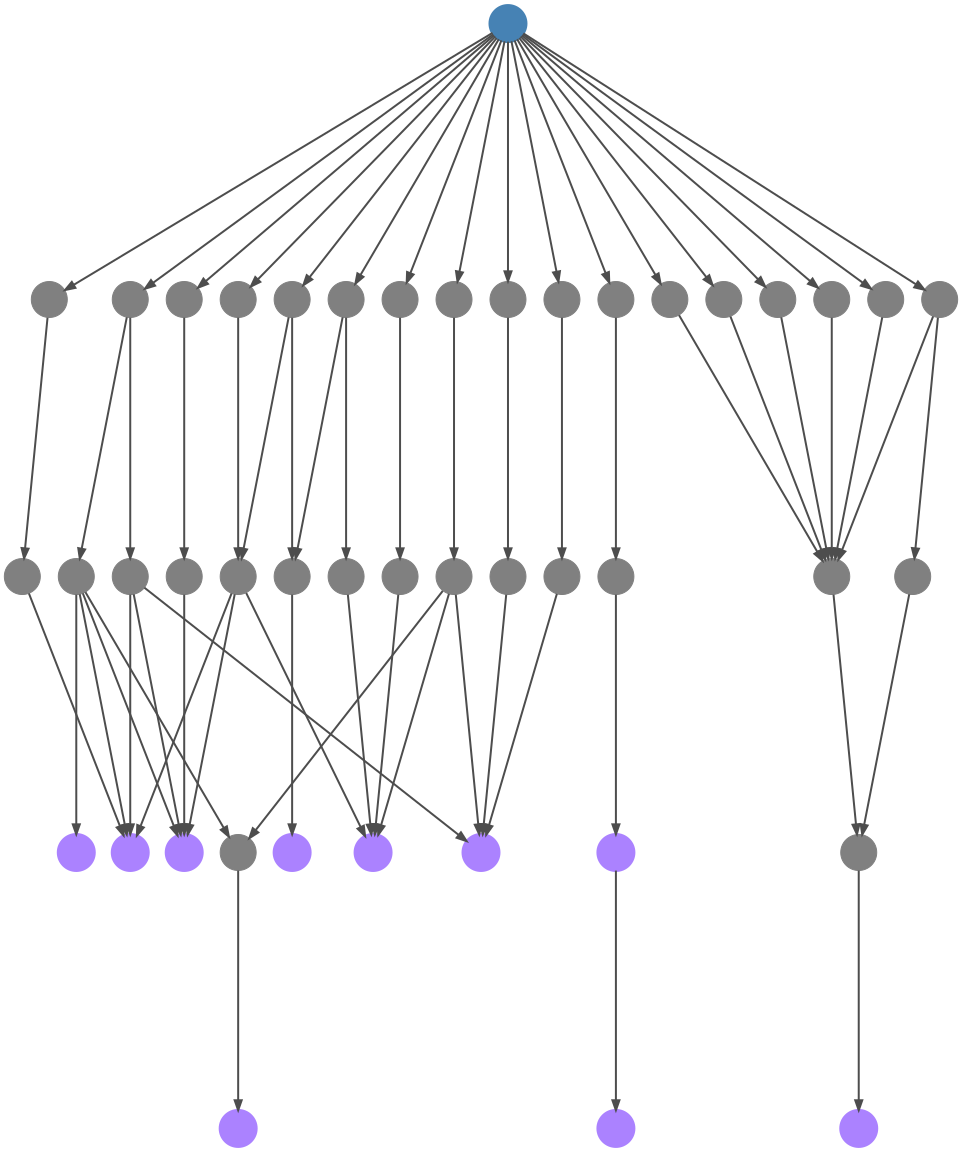

In [14]:
a = nc.visualize_graph_simple(shortest_path_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

We can use the signs of the network to add an additional layer of constrain to the problem by removing the paths which are not coherent in terms of sign. The algorithm computes an overall sign of the path by multiplying the signs of the edges contained in said path, and then evaluates whether perturbation_sign * path_sign = measurement_sign. If it does not, the path is discarded.

In [15]:
shortest_sc_network, shortest_sc_list = nc.run_sign_consistency(shortest_path_network, shortest_paths_list, sources, measurements)

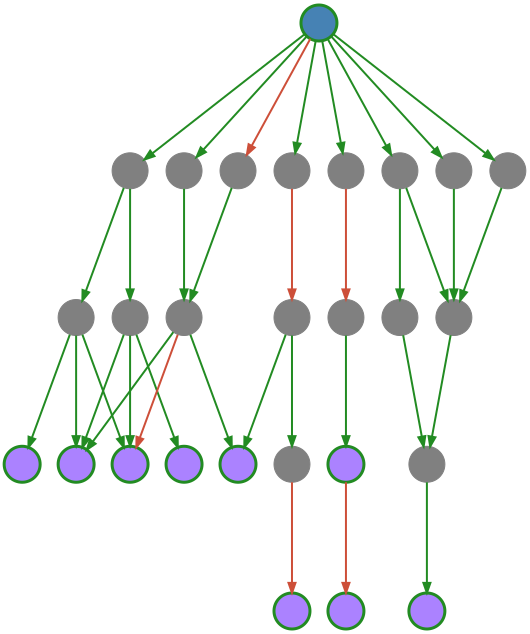

In [16]:
a = nc.visualize_graph_simple(shortest_sc_network, sources, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

**Shortest paths**

As an alternative method, we can retrieve all possible paths (within a limit, due to computational constrains) between source and measurements layers. This might help us capture additional biological information which might not be available when considering more restrictive methods, such as shortest paths.

In [19]:
all_paths_network, all_paths_list = nc.run_all_paths(graph, sources, measurements, depth_cutoff=4)

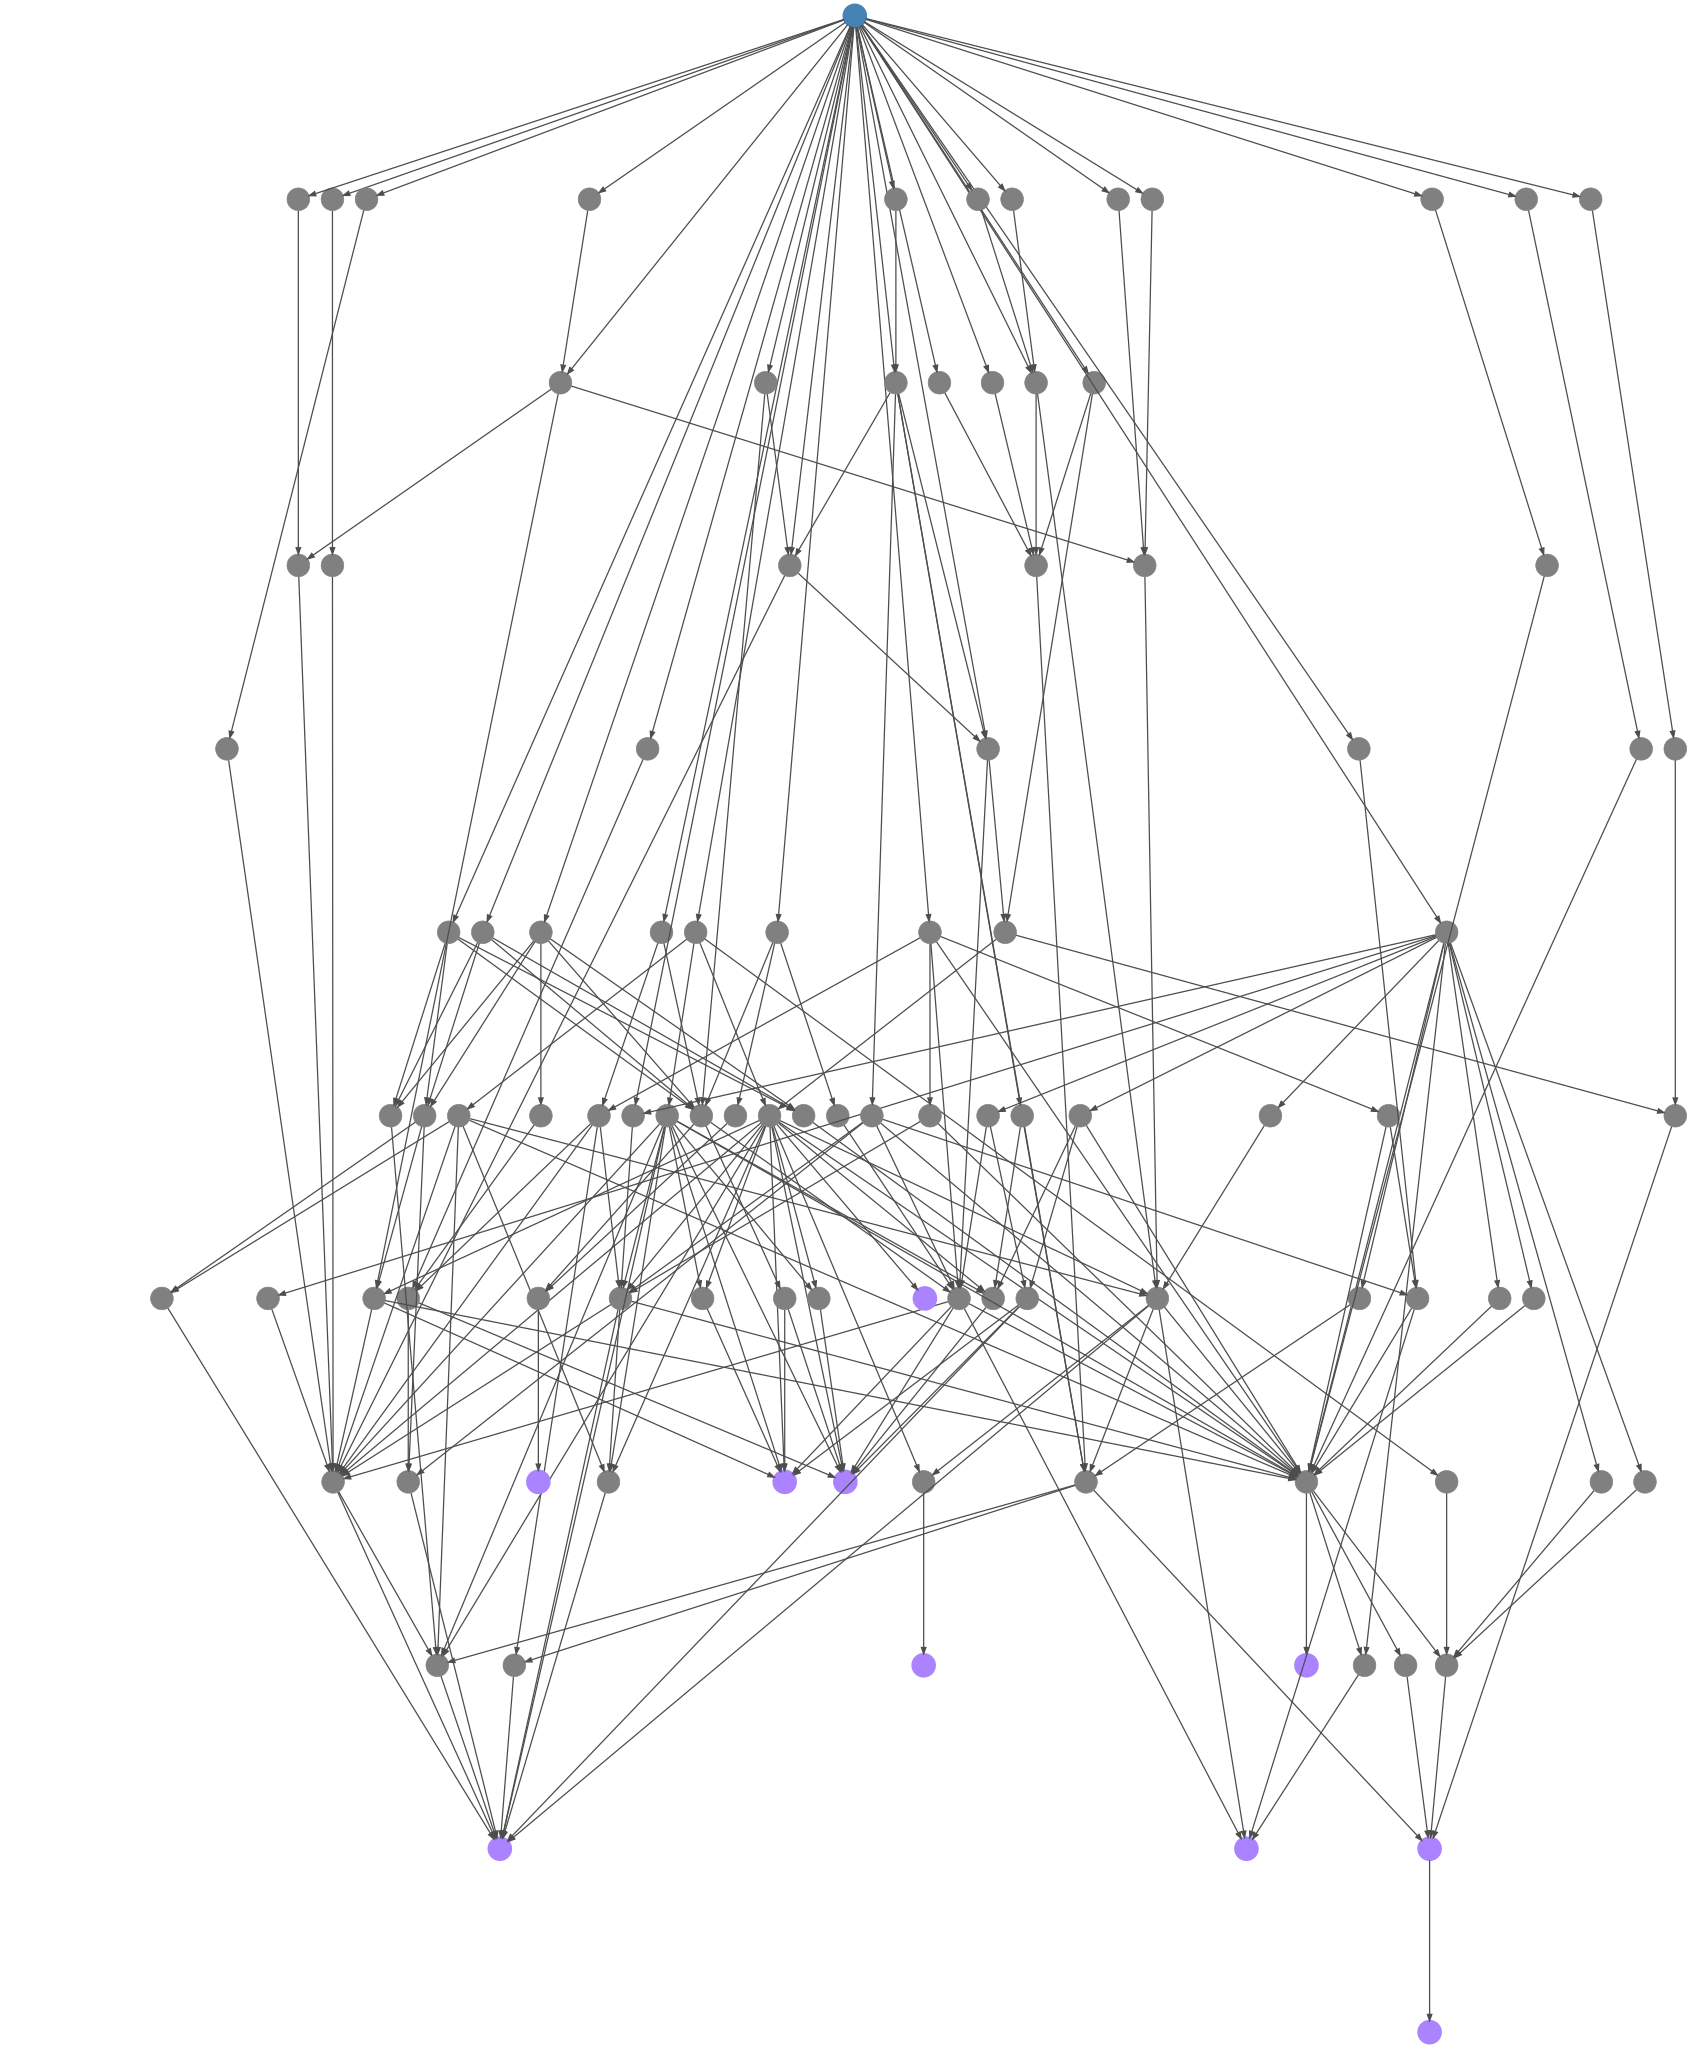

In [20]:
a = nc.visualize_graph_simple(all_paths_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

Like in the previous case, we can apply an additional constrain by removing non-coherent paths in terms of signed interactions.

In [22]:
allpaths_sc_network, allpaths_sc_list = nc.run_sign_consistency(all_paths_network, all_paths_list, sources, measurements)

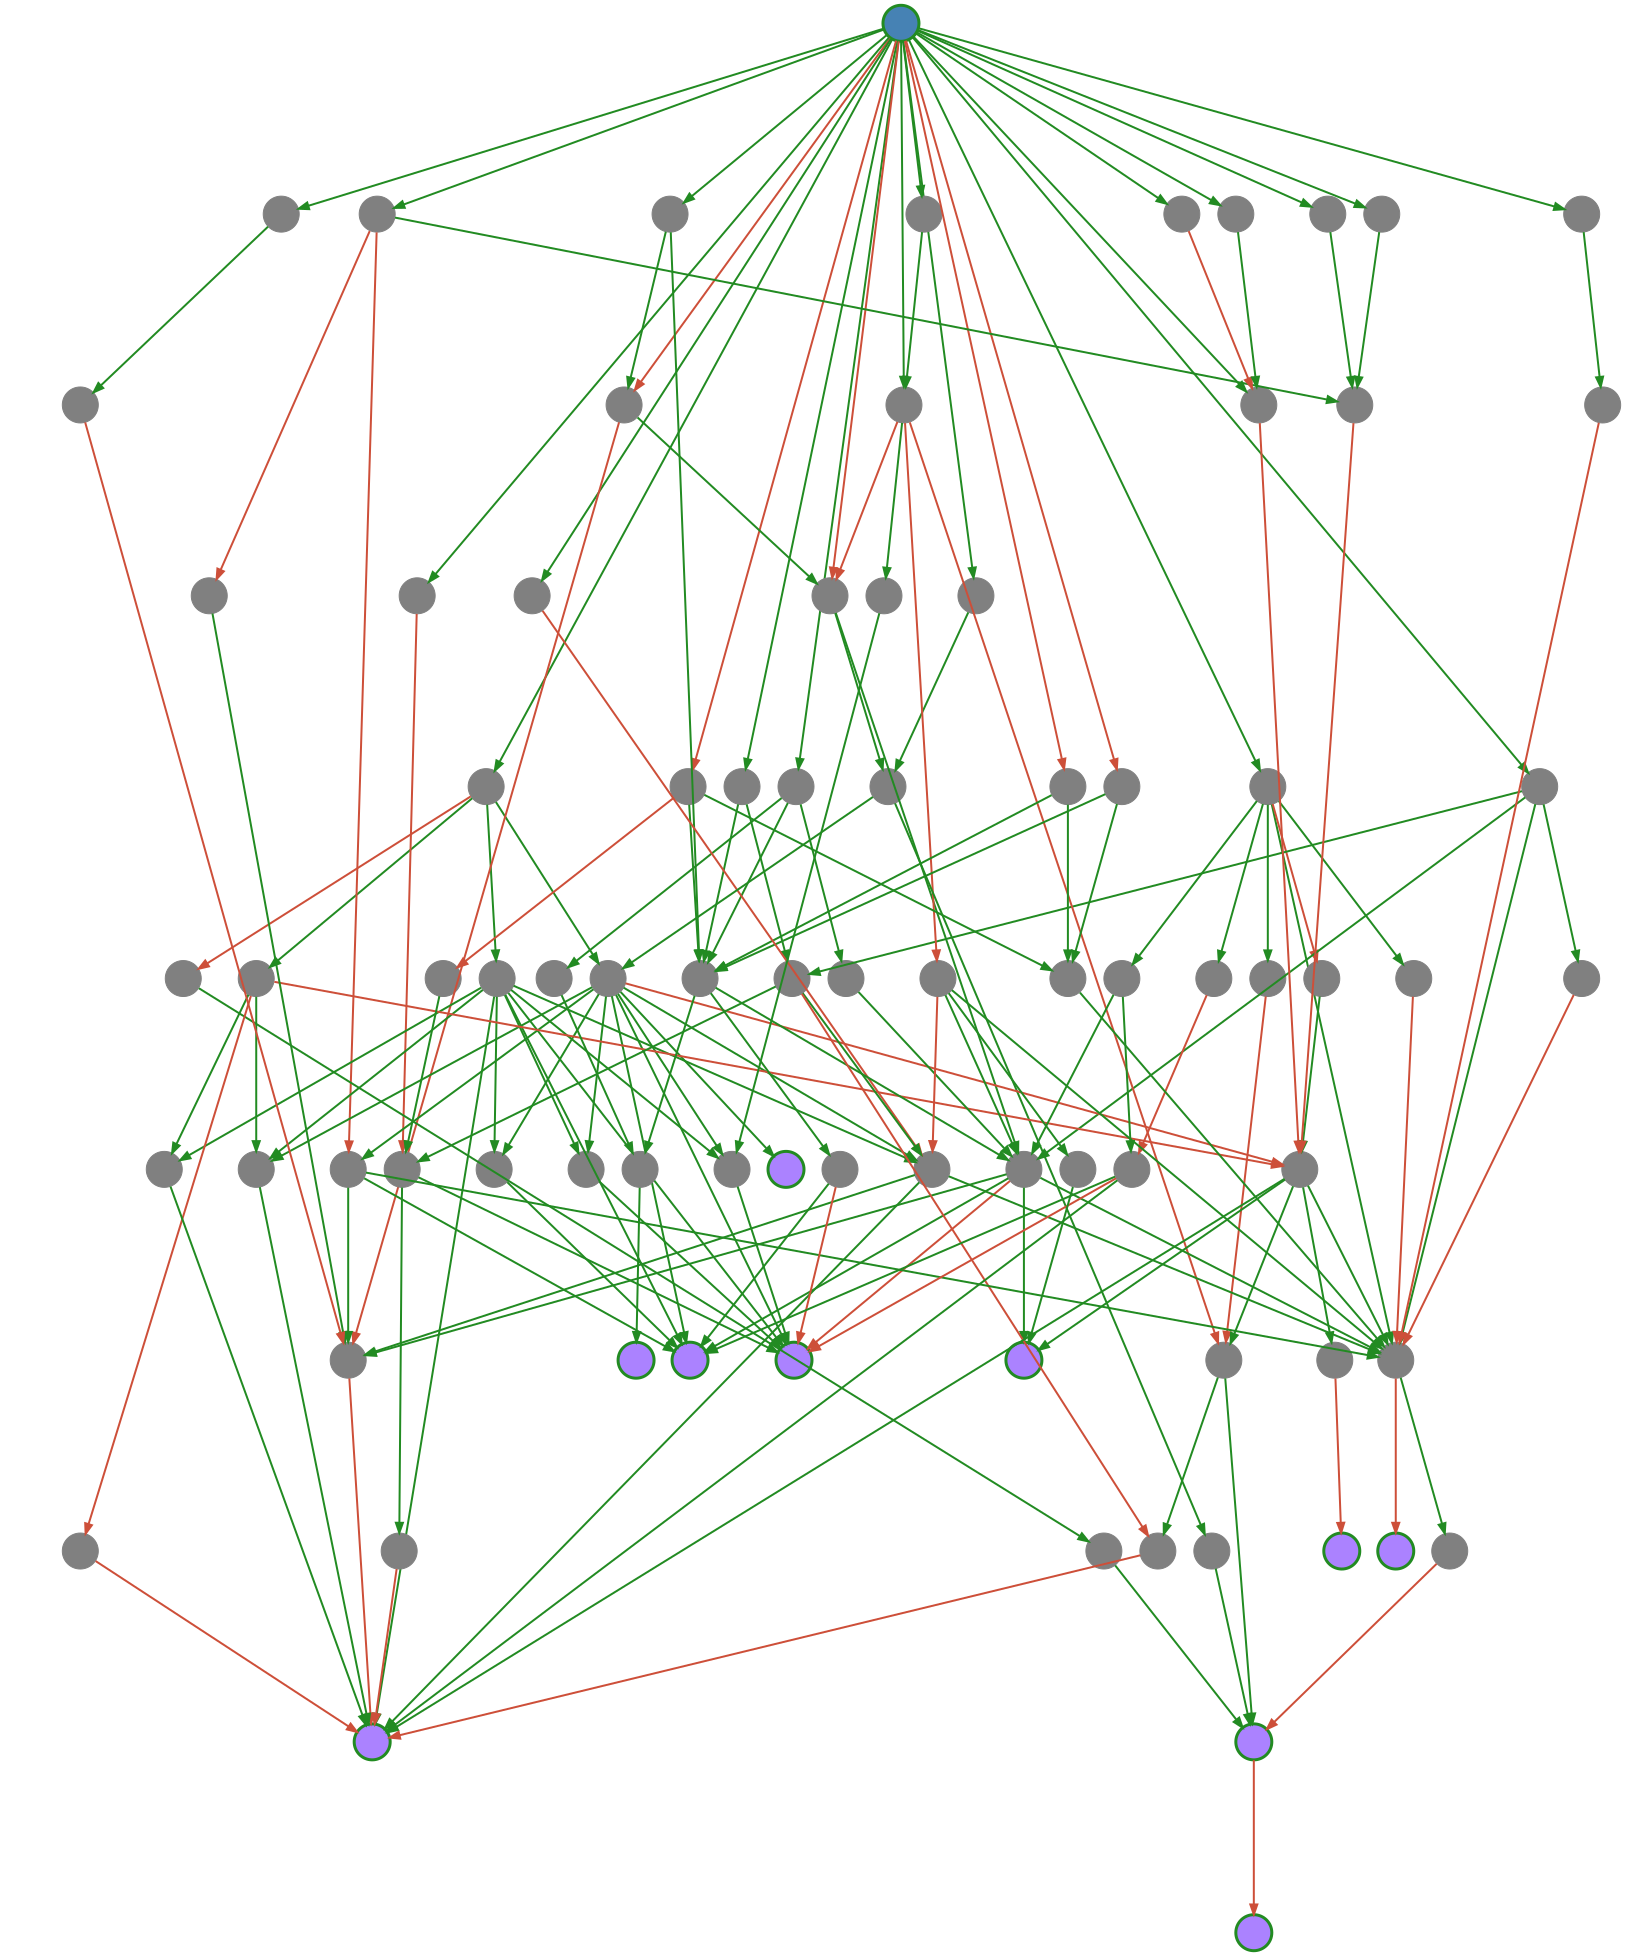

In [23]:
a = nc.visualize_graph_simple(allpaths_sc_network, sources, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

**Personalised PageRank**

Several other methods follow a heat diffusion philosophy: "heat" propagates using the network topology and the "hottest" nodes are in the perturbation/measurement layers, cooling down the further away from these layers a node is.
In our approach, we use personalised PageRank (PPR), in which the probabilities of the random walker are altered, as a computationally inexpensive approach to this philosophy.
We compute PPR values starting from both perturbation and measurement layers, and then by applying a threshold (top % nodes with highest PPR value) we retrieve only the network which is most accessible from these two layers.

In [50]:
ppr_network = nc.add_pagerank_scores(graph, sources, measurements, personalize_for='source')
ppr_network = nc.add_pagerank_scores(ppr_network, sources, measurements, personalize_for='target')

ppr_network = nc.compute_ppr_overlap(ppr_network, percentage=1)

Now, we can use a path-recover method, such as shortest paths or all paths, to retrieve a smaller subnetwork.

In [51]:
shortest_ppr_network, shortest_ppr_list = nc.run_shortest_paths(ppr_network, sources, measurements)

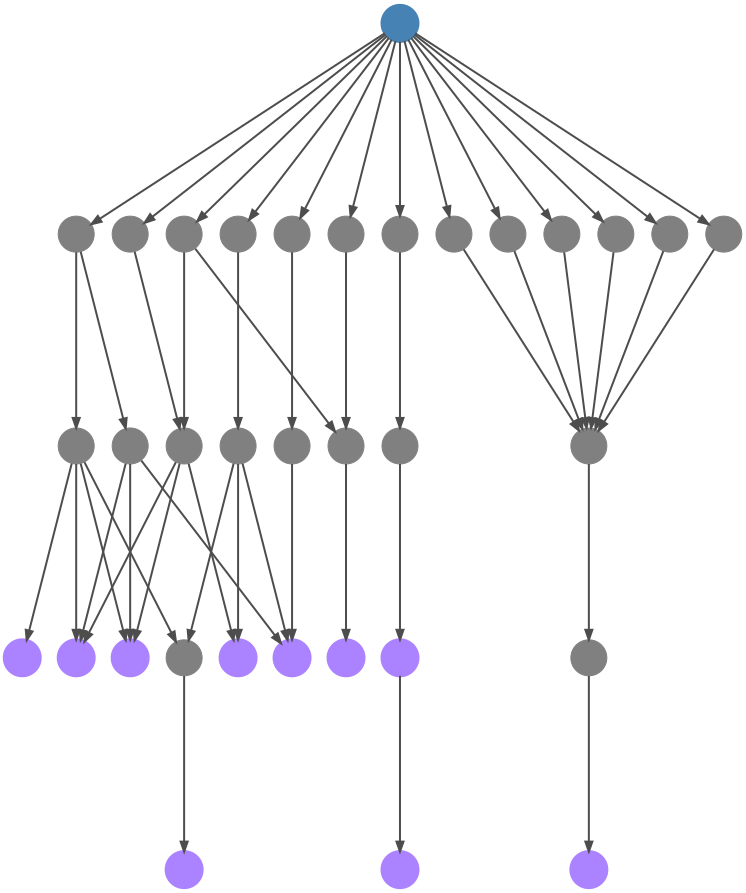

In [52]:
a = nc.visualize_graph_simple(shortest_ppr_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

We can also add sign consistency checks:

In [54]:
shortest_sc_ppr_network, shortest_sc_ppr_list = nc.run_sign_consistency(shortest_ppr_network, shortest_ppr_list, sources, measurements)

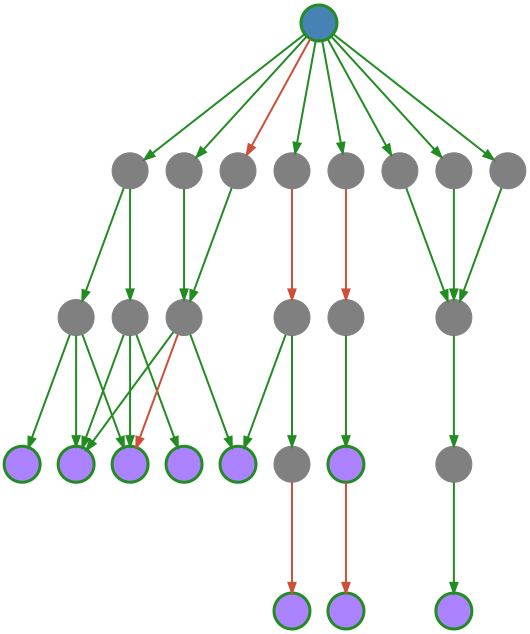

In [55]:
a = nc.visualize_graph_simple(shortest_sc_ppr_network, sources, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)